# Data Preprocessing and Advanced Modeling

This notebook is focused on applying data preprocessing and using the previous baseline models to create ensemble learning models as well us a neural network model on a dataset of 2022 annual CDC survey data of 400k+ adults related to their health status.

The goal is to develop an efficient machine learning model to predict an individual's propensity to having a heart disease.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from tempfile import mkdtemp
cachedir = mkdtemp()

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

## Table of Contents

1. [Data Preprocessing](#datapreprocessing)
2. [Using a Random Forest Classifier for feature selection](#logisticregression)
3. [Using Ensemble Learning Methods](#ensembles)
4. [Using an Adaptive Boosting Classifier](#adaboost)
5. [Using a Neural Network Model](#neuralnetwork)

In [63]:
from google.colab import drive
#drive.mount('/content/drive')

drive.mount("/content/drive", force_remount=True)

# Check for the file/folder paths
!ls "/content/drive/My Drive/Colab Notebooks/data/"

data_path = "/content/drive/My Drive/Colab Notebooks/data/"
df = pd.read_csv(data_path + "cleaned_data.csv")

Mounted at /content/drive
anomaly.csv  cleaned_data.csv  db.csv


## Data Preprocessing<a name="datapreprocessing"></a>

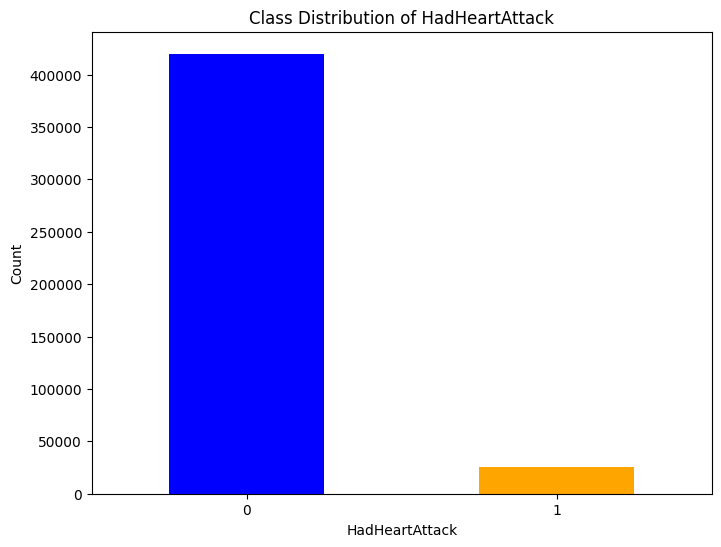

In [26]:
class_count = df["HadHeartAttack"].value_counts() #Exploring the target variable

# Plotting the class distribution
plt.figure(figsize=(8, 6))
class_count.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution of HadHeartAttack')
plt.xlabel('HadHeartAttack')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Train/Test Split

In [27]:
#Splitting the data into train and test sets

X = df.drop(columns = ['HadHeartAttack'])
y = df['HadHeartAttack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

### Dealing with class imbalance by Oversampling the Minority Class and Undersampling the majority class

In [28]:
# Oversampling the minority class to a ratio of 0.5 over the majority class
over = RandomOverSampler(sampling_strategy=0.5)

# fit and apply the transform
X_train_bal, y_train_bal = over.fit_resample(X_train, y_train)

# Undersampling the majority class to a ratio of 1:1 over the minority class
under = RandomUnderSampler(sampling_strategy=1)

# fit and apply the transform
X_train_bal, y_train_bal = under.fit_resample(X_train_bal, y_train_bal)

## Using a Random Forest Classifier for Feature Selection<a name="rfc"></a>

In [29]:
from sklearn.ensemble import RandomForestClassifier

estimators = [('normalise', StandardScaler()),
              ('rfc', RandomForestClassifier(random_state=42))]

pipe = Pipeline(estimators, memory = cachedir)

params = {'rfc__n_estimators': [10,20,30],
         'rfc__max_depth': [1,2,5,7,10],
         'rfc__min_samples_split': [2,4,7]}


grid_search = GridSearchCV(pipe, param_grid=params, scoring='roc_auc')

fitted_search_rfc = grid_search.fit(X_train_bal, y_train_bal)

#Evaluating on the AUC score
auc_trainscore = fitted_search_rfc.best_score_
print(f"AUC score on the train set: {auc_trainscore}")

AUC score on the train set: 0.8872669606990046


In [30]:
fitted_search_rfc.best_params_

{'rfc__max_depth': 10, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 30}

### Model Evaluation

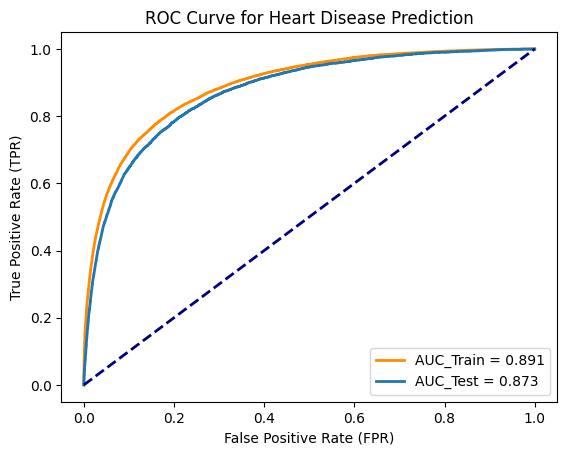

AUC_Train:0.8909480845238789
AUC_Test:0.873230430666684


In [31]:
bestrfc_model = fitted_search_rfc.best_estimator_

y_proba_train = bestrfc_model.predict_proba(X_train_bal)[:,1]
y_proba_test = bestrfc_model.predict_proba(X_test)[:,1]

fprs_train, tprs_train, thresholds_train = roc_curve(y_train_bal, y_proba_train)
fprs_test, tprs_test, thresholds_test = roc_curve(y_test, y_proba_test)
roc_auc_train = roc_auc_score(y_train_bal, y_proba_train)
roc_auc_test = roc_auc_score(y_test, y_proba_test)

plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange',
         lw=2, label='AUC_Train = %0.3f' % roc_auc_train)
plt.plot(fprs_test, tprs_test, lw=2, label='AUC_Test = %0.3f' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Heart Disease Prediction')
plt.legend(loc="best")
plt.show()

print(f'AUC_Train:{roc_auc_train}')
print(f'AUC_Test:{roc_auc_test}')

With a Test AUC Score of 0.873, it is doing well in distinguishing between individuals who have had a heart attack and individuals who haven't.

In [32]:
# Specify the desired FPR
desired_fpr = 0.2

# Find the index of the point on the ROC curve closest to the desired FPR or TPR
index_at_desired_fpr = np.argmin(np.abs(fprs_test - desired_fpr))

# Get the corresponding threshold values
threshold_at_desired_fpr = thresholds_test[index_at_desired_fpr]
tpr_at_desired_fpr = tprs_test[index_at_desired_fpr]


print(f"Threshold at desired FPR ({desired_fpr}): {threshold_at_desired_fpr}")
print(f"TPR at desired FPR ({desired_fpr}): {tpr_at_desired_fpr}")

Threshold at desired FPR (0.2): 0.49615905479114086
TPR at desired FPR (0.2): 0.7837323608688759


For a false positive rate of about 0.2, the true positive rate will be 0.79 at a threshold of 0.49

In [33]:
# Get feature names and importances
feature_names = X.columns.tolist()
importances = bestrfc_model.named_steps['rfc'].feature_importances_


feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(feature_importance_df)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

                                               Feature  Importance
68                                       HadAngina_Yes    0.268953
69                                       HadStroke_Yes    0.073644
91                                       ChestScan_Yes    0.068557
97                                   AgeCategory_older    0.067376
75                                    HadArthritis_Yes    0.066326
77                                     HadDiabetes_Yes    0.056135
82                               DifficultyWalking_Yes    0.050659
67                                    RemovedTeeth_All    0.029908
1                                   PhysicalHealthDays    0.028035
72                                         HadCOPD_Yes    0.027442
0                                                  Sex    0.026644
58                                  GeneralHealth_Fair    0.026077
102                                  PneumoVaxEver_Yes    0.022945
74                                HadKidneyDisease_Yes    0.01

The state features generally rank low in feature importance, indicating that they are not relevant in predicting whether or not an individual will have a heart disease. Next step will be to remove them from the dataset to improve performance.

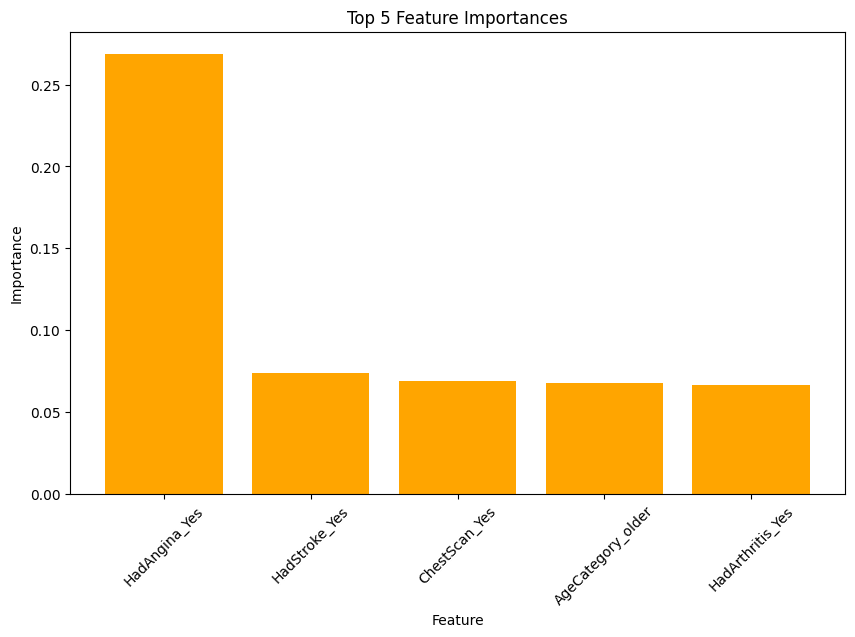

In [34]:
# Top 5 Most Important Features


top_features = feature_importance_df.head(5)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Importance'], color='orange')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 5 Feature Importances')
plt.xticks(rotation=45)
plt.show()


The chart above shows the top 5 most important features in predicting heart disease.

## Removing the State Features

In [35]:
states = ['State_Alaska','State_Arizona','State_Arkansas','State_California','State_Colorado','State_Connecticut',
          'State_Delaware','State_District of Columbia','State_Florida','State_Georgia','State_Guam','State_Hawaii',
          'State_Idaho','State_Illinois','State_Indiana','State_Iowa','State_Kansas','State_Kentucky','State_Louisiana',
         'State_Maine','State_Maryland','State_Massachusetts','State_Michigan','State_Minnesota','State_Mississippi',
         'State_Missouri','State_Montana','State_Nebraska','State_Nevada','State_New Hampshire','State_New Jersey',
         'State_New Mexico','State_New York','State_North Carolina','State_North Dakota','State_Ohio','State_Oklahoma',
         'State_Oregon','State_Pennsylvania','State_Puerto Rico','State_Rhode Island','State_South Carolina','State_South Dakota',
         'State_Tennessee','State_Texas','State_Utah','State_Vermont','State_Virgin Islands','State_Virginia','State_West Virginia',
         'State_Wisconsin','State_Wyoming']

X_train_bal.drop(columns = states, inplace = True)
X_test.drop(columns = states, inplace = True)

Next step is to explore some advanced machine learning methods

## Using Ensemble Learning Methods <a name="ensembles"></a>

## Using a Voting Classifier

Using the best previous baseline models to fit a voting classifier, that is the logistic Regression Model applied in Sprint 2 and the previous Random Forest Classifier

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier


log_model = LogisticRegression(C=0.01, random_state=42)
rfc_model = RandomForestClassifier(max_depth = 10, min_samples_split = 2, n_estimators = 30, random_state=42)


estimators = [('normalise', StandardScaler()),
              ('votingclassifier', VotingClassifier(
              estimators=[('log',log_model),('rf',rfc_model)],
              voting = 'soft'))]

pipe = Pipeline(estimators)

pipe.fit(X_train_bal, y_train_bal)

# Predict probabilities for both training and test sets
train_probs = pipe.predict_proba(X_train_bal)[:, 1]
test_probs = pipe.predict_proba(X_test)[:, 1]

# Calculate AUC score
train_auc = roc_auc_score(y_train_bal, train_probs)
test_auc = roc_auc_score(y_test, test_probs)


### Model Evaluation

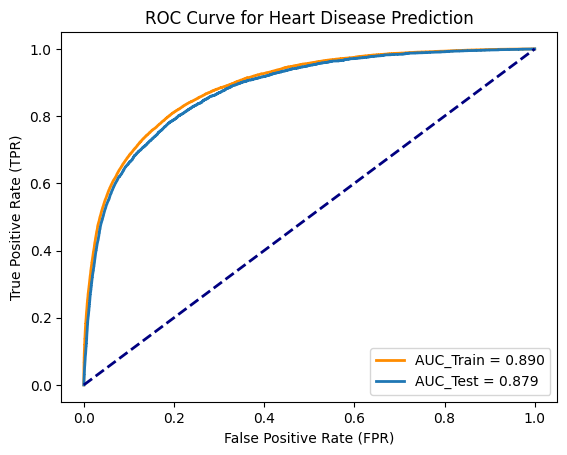

AUC score on the training set: 0.890039561556773
AUC score on the test set: 0.8794038675275806


In [41]:
fprs_train, tprs_train, thresholds_train = roc_curve(y_train_bal, train_probs)
fprs_test, tprs_test, thresholds_test = roc_curve(y_test, test_probs)

plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange',
         lw=2, label='AUC_Train = %0.3f' % train_auc)
plt.plot(fprs_test, tprs_test, lw=2, label='AUC_Test = %0.3f' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Heart Disease Prediction')
plt.legend(loc="best")
plt.show()

print(f"AUC score on the training set: {train_auc}")
print(f"AUC score on the test set: {test_auc}")

With a Test AUC Score of 0.879, it is doing well in distinguishing between individuals who have had a heart attack and individuals who haven't.

In [42]:
# Specify the desired FPR
desired_fpr = 0.2

# Find the index of the point on the ROC curve closest to the desired FPR or TPR
index_at_desired_fpr = np.argmin(np.abs(fprs_test - desired_fpr))

# Get the corresponding threshold values
threshold_at_desired_fpr = thresholds_test[index_at_desired_fpr]
tpr_at_desired_fpr = tprs_test[index_at_desired_fpr]


print(f"Threshold at desired FPR ({desired_fpr}): {threshold_at_desired_fpr}")
print(f"TPR at desired FPR ({desired_fpr}): {tpr_at_desired_fpr}")

Threshold at desired FPR (0.2): 0.46335727840049235
TPR at desired FPR (0.2): 0.7889646424607579


For a false positive rate of about 0.2, the true positive rate will be 0.79 at a threshold of 0.46

## Using an Adaptive Boosting Classifier <a name="adaboost"></a>

Using the previous voting classifier to build an adaptive boosting classifier

In [43]:
from sklearn.ensemble import AdaBoostClassifier


log_model = LogisticRegression(C=0.01, random_state=42)
rfc_model = RandomForestClassifier(max_depth = 10, min_samples_split = 2, n_estimators = 30, random_state=42)
vc = VotingClassifier(estimators=[('log',log_model),('rf',rfc_model)],voting = 'soft')


estimators = [('normalise', StandardScaler()),
              ('ac', AdaBoostClassifier(base_estimator=vc))]

pipe = Pipeline(estimators)

params = {'ac__learning_rate': [0.01,0.03,0.05,0.07,0.1]}

grid_search = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', verbose=0)

fitted_search_ada = grid_search.fit(X_train_bal, y_train_bal)

auc_trainscore = fitted_search_ada.best_score_
print(f"AUC score on the train set: {auc_trainscore}")

AUC score on the train set: 0.9049234721188757


In [44]:
fitted_search_ada.best_params_

{'ac__learning_rate': 0.1}

### Model Evaluation

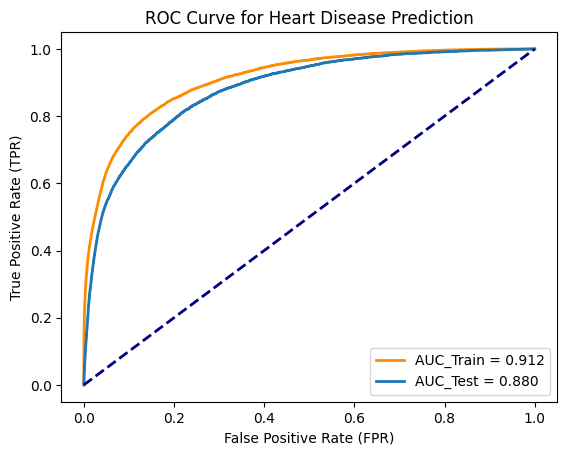

AUC_Train:0.9115435951220082
AUC_Test:0.8802377427120689


In [45]:
bestada_model = fitted_search_ada.best_estimator_

y_probs_train = bestada_model.predict_proba(X_train_bal)[:,1]
y_probs_test = bestada_model.predict_proba(X_test)[:,1]

fprs_train, tprs_train, thresholds_train = roc_curve(y_train_bal, y_probs_train)
fprs_test, tprs_test, thresholds_test = roc_curve(y_test, y_probs_test)
roc_auc_train = roc_auc_score(y_train_bal, y_probs_train)
roc_auc_test = roc_auc_score(y_test, y_probs_test)

plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange',
         lw=2, label='AUC_Train = %0.3f' % roc_auc_train)
plt.plot(fprs_test, tprs_test, lw=2, label='AUC_Test = %0.3f' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Heart Disease Prediction')
plt.legend(loc="best")
plt.show()

print(f'AUC_Train:{roc_auc_train}')
print(f'AUC_Test:{roc_auc_test}')

In [46]:
# Specify the desired FPR
desired_fpr = 0.2

# Find the index of the point on the ROC curve closest to the desired FPR or TPR
index_at_desired_fpr = np.argmin(np.abs(fprs_test - desired_fpr))

# Get the corresponding threshold values
threshold_at_desired_fpr = thresholds_test[index_at_desired_fpr]
tpr_at_desired_fpr = tprs_test[index_at_desired_fpr]


print(f"Threshold at desired FPR ({desired_fpr}): {threshold_at_desired_fpr}")
print(f"TPR at desired FPR ({desired_fpr}): {tpr_at_desired_fpr}")

Threshold at desired FPR (0.2): 0.4916575160754697
TPR at desired FPR (0.2): 0.790391628349453


In [64]:
## Saving the adaptive boosting classifier for production

import joblib


drive_path = "/content/drive/My Drive/Colab Notebooks/data/model.pkl"

# Pickle the model
joblib.dump(bestada_model, drive_path)

['/content/drive/My Drive/Colab Notebooks/data/model.pkl']

## Using a Neural Network Model <a name="neuralnetwork"></a>

Reprocessing and splitting the data to drop the state features and include a validation set

In [65]:
states = ['State_Alaska','State_Arizona','State_Arkansas','State_California','State_Colorado','State_Connecticut',
          'State_Delaware','State_District of Columbia','State_Florida','State_Georgia','State_Guam','State_Hawaii',
          'State_Idaho','State_Illinois','State_Indiana','State_Iowa','State_Kansas','State_Kentucky','State_Louisiana',
         'State_Maine','State_Maryland','State_Massachusetts','State_Michigan','State_Minnesota','State_Mississippi',
         'State_Missouri','State_Montana','State_Nebraska','State_Nevada','State_New Hampshire','State_New Jersey',
         'State_New Mexico','State_New York','State_North Carolina','State_North Dakota','State_Ohio','State_Oklahoma',
         'State_Oregon','State_Pennsylvania','State_Puerto Rico','State_Rhode Island','State_South Carolina','State_South Dakota',
         'State_Tennessee','State_Texas','State_Utah','State_Vermont','State_Virgin Islands','State_Virginia','State_West Virginia',
         'State_Wisconsin','State_Wyoming']

df.drop(columns = states, inplace = True)

In [66]:
X = df.drop(columns = ['HadHeartAttack'])
y = df['HadHeartAttack']

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=2)

In [67]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.5)

# fit and apply the transform
X_train_bal, y_train_bal = over.fit_resample(X_train, y_train)

# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=1)

# fit and apply the transform
X_train_bal, y_train_bal = under.fit_resample(X_train_bal, y_train_bal)

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_bal)
X_scaled_train_bal = scaler.transform(X_train_bal)
X_scaled_test = scaler.transform(X_test)
X_scaled_val = scaler.transform(X_val)

In [70]:
import random

def set_random_seed(seed):

    '''Random seeds for reproducability'''

    random.seed(seed)
    tf.random.set_seed(seed)

In [71]:
dropout_rate = [0,0.1,0.15,0.2]
optimizer_func = ['adam','sgd']
best_test_auc = -math.inf

set_random_seed(123)

for opt in optimizer_func:
  for rate in dropout_rate:
    # Create a new sequential model
    model = keras.Sequential()

    # Declare the hidden layers
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dropout(rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dropout(rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dropout(rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dropout(rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dropout(rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dropout(rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dropout(rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dropout(rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dropout(rate))
    model.add(layers.BatchNormalization())

    # Declare the output layer
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=opt,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.AUC(name='auc')]
    )

    # Train the network
    from tensorflow.keras.callbacks import EarlyStopping

    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(X_scaled_train_bal, y_train_bal, epochs=1000, verbose=0, validation_data=(X_scaled_val, y_val), callbacks=[early_stopping], batch_size=5000)

    train_auc = history.history["auc"][-1]
    result = model.evaluate(X_scaled_test, y_test, verbose=0)
    test_auc = result[1]

    if test_auc > best_test_auc:
      best_test_auc = test_auc
      best_train_auc = train_auc
      best_optimizer_func = opt
      best_dropout_rate = rate
      predictions_test = model.predict(X_scaled_test)
      predictions_train = model.predict(X_scaled_train_bal)

print(f'Train_AUC: {best_train_auc}')
print(f'Test_AUC: {best_test_auc}')
print(f'Optimzer: {best_optimizer_func}')
print(f'Dropout Rate: {best_dropout_rate}')

7871/7871 [==============================] - 26s 3ms/step
Train_AUC: 0.9054885506629944
Test_AUC: 0.8822344541549683
Optimzer: adam
Dropout Rate: 0.2


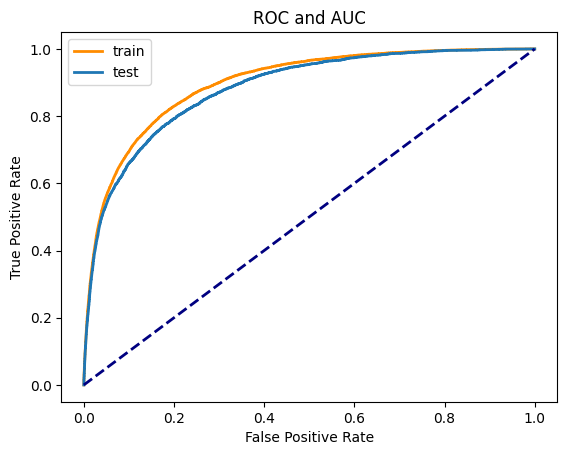

Train AUC score: 0.8973946573241673
Test AUC score: 0.8822583786990623


In [72]:
from sklearn.metrics import roc_curve, roc_auc_score

#Get the probability for each point
y_proba_test = predictions_test[:,0]
y_proba_train = predictions_train[:,0]

# Compute ROC curve and AUC
fprs_train, tprs_train, thresholds_train = roc_curve(y_train_bal, y_proba_train)
roc_auc_train = roc_auc_score(y_train_bal, y_proba_train)
fprs_test, tprs_test, thresholds_test = roc_curve(y_test, y_proba_test)
roc_auc_test = roc_auc_score(y_test, y_proba_test)

# Plot the ROC curve.
plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange', lw=2, label='train')
plt.plot(fprs_test, tprs_test, lw=2, label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="best")
plt.show()

print(f"Train AUC score: {roc_auc_train}")
print(f"Test AUC score: {roc_auc_test}")

Test AUC Score improved slightly to 0.882

In [73]:
# Specify the desired FPR
desired_fpr = 0.2

# Find the index of the point on the ROC curve closest to the desired FPR or TPR
index_at_desired_fpr = np.argmin(np.abs(fprs_test - desired_fpr))

# Get the corresponding threshold values
threshold_at_desired_fpr = thresholds_test[index_at_desired_fpr]
tpr_at_desired_fpr = tprs_test[index_at_desired_fpr]


print(f"Threshold at desired FPR ({desired_fpr}): {threshold_at_desired_fpr}")
print(f"TPR at desired FPR ({desired_fpr}): {tpr_at_desired_fpr}")

Threshold at desired FPR (0.2): 0.4379896819591522
TPR at desired FPR (0.2): 0.7923594615993665
